In [1]:
import pandas as pd
import matplotlib
import string
import matplotlib.pyplot as plt
import json
import io

#import sklearn
#!pip install --upgrade scikit-learn==0.20.3
#!pip install stop-words
import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Convertendo dados em dataFrame

In [2]:
#Coleta dos dados
BASE_DATA_PATH="data/"
TRAINING_FILE_NAME="training.json"
TEST_FILE_FEATURES_NAME="testcase/testcases/input00.txt"
TEST_FILE_LABEL_NAME="testcase/testcases/output00.txt"

def base_read_dataset(f_name):
    f = open(BASE_DATA_PATH+f_name, "r", encoding='utf-8')
    # descarta a primeira linha que contém apenas um número inteiro
    first_line = f.readline()

    df_aux = []
    l_number = 0
    for line in f:
        json_line = json.loads(line)
        df_aux.append(pd.DataFrame.from_records(json_line, index=[l_number]))
        l_number+=1
    df = pd.concat(df_aux)
    return(df)

def read_test_dataset(f_input_name, f_output_name):
    df = base_read_dataset(f_input_name)
#     pd.read_json(BASE_DATA_PATH+f_input_name, orient='records')
    df_label = pd.read_csv(BASE_DATA_PATH+f_output_name, header=None, names=['label'])
    df['topic'] = df_label['label']
    return(df)

df = base_read_dataset(TRAINING_FILE_NAME)
df_test = read_test_dataset(TEST_FILE_FEATURES_NAME, TEST_FILE_LABEL_NAME)

# Exploração dos dados

In [3]:
df

,excerpt,question,topic
0,"I'm trying to work out, in general terms, the ...",What is the effective differencial effective o...,electronics
1,Can I know which component senses heat or acts...,Heat sensor with fan cooling,electronics
2,I am replacing a wall outlet with a Cooper Wir...,Outlet Installation--more wires than my new ou...,electronics
3,"i have been reading about the buck converter, ...",Buck Converter Operation Question,electronics
4,I need help with deciding on a Master's Projec...,"Urgent help in area of ASIC design, verificati...",electronics
...,...,...,...
20214,I have a Custom Post Type called Recipe with p...,How to set a Custom Post Type as the parent of...,wordpress
20215,I'm using the code below to track when a user ...,Tracking last login and last visit,wordpress
20216,"add_action( 'pre_get_posts', 'custom_pre_get_p...",How to exclude the particular category from th...,wordpress
20217,i have wordpress blog with many posts. each po...,display sub categories assoccited with each po...,wordpress


In [4]:
df_test

,excerpt,question,topic
0,I have been working with a IS5 frequency inver...,Frequency Inverter LS IS5,electronics
1,I was taking apart this thing that I bought fr...,Why did the designer use this motor?,electronics
2,I am starting to learn to use operational ampl...,Help with amplifier with feedback,electronics
3,This may be a very basic question but as the u...,Single Supply Op Amp to Amplify 0-3.3V to 0-10V,electronics
4,I am new to all of this and I really feel over...,How to start with 3d tracking? [on hold],electronics
...,...,...,...
15027,In the function websitez_detect_mobile_device ...,Add exception to WP Mobile Detector,wordpress
15028,"I wanted to display top viewed posts by month,...",Query Problem in getting top viewed posts,wordpress
15029,I'm trying to translate Woosidebars strings i...,Translate Woosidebars plugin strings,wordpress
15030,I hope this is not a duplicate question.\n\nI ...,Fatal error: Allowed memory size of 37748736 b...,wordpress


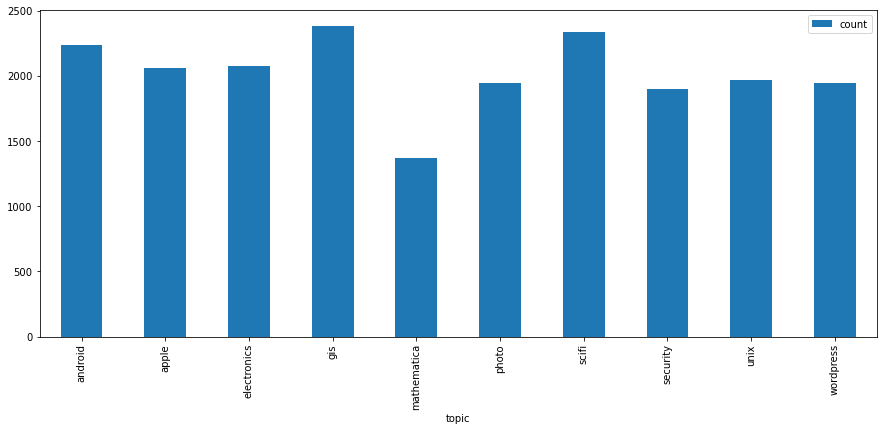

In [5]:
topis_dist = df.groupby('topic').size().reset_index()
topis_dist = topis_dist.rename(columns={0: 'count'})
topis_dist.plot(kind='bar', x="topic", y="count", figsize=(15,6))
plt.show()

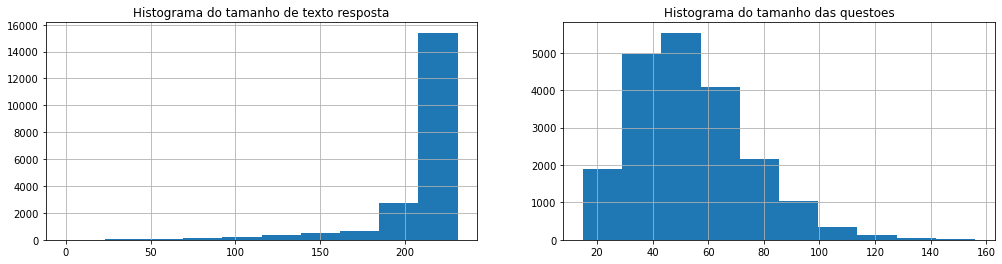

<AxesSubplot:title={'center':'Media de tamanho de questao por topico'}, xlabel='topic'>

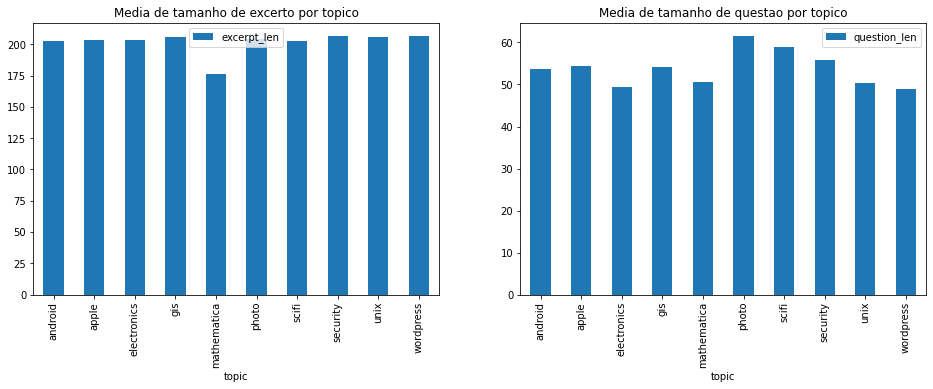

In [6]:
# DISPLAY HISTOGRAM
df["excerpt_len"] = df["excerpt"].apply(lambda x: len(x))
df["question_len"] = df["question"].apply(lambda x: len(x))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17,4))

axes[0].set_title("Histograma do tamanho de texto resposta")
df["excerpt_len"].hist(ax=axes[0], bins=10)
axes[1].set_title("Histograma do tamanho das questoes")
df["question_len"].hist(ax=axes[1])

plt.show()

# DISPLAY BAR CHARTS
df_grouped = df.groupby("topic").agg({'excerpt_len': 'mean', 'question_len': 'mean'}).reset_index()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
axes[0].set_title("Media de tamanho de excerto por topico")
df_grouped.plot.bar(x="topic", y="excerpt_len", ax=axes[0])
axes[1].set_title("Media de tamanho de questao por topico")
df_grouped.plot.bar(x="topic", y="question_len", ax=axes[1])

 # Criando features

In [7]:
full_text_col = 'full_text'
required_columns = ["excerpt", "question", "topic", full_text_col]
df[full_text_col] = df["question"] + " " + df["excerpt"]
df[full_text_col] = df[full_text_col].str.lower()

le = LabelEncoder()

X = df[full_text_col]
y = le.fit_transform(df['topic'])

df_test[full_text_col] = df_test["question"] + " " + df_test["excerpt"]
df_test[full_text_col] = df_test[full_text_col].str.lower()
X_final_test = df_test[full_text_col]
y_final_test = le.fit_transform(df_test['topic'])

In [19]:
len(y)

20219

In [9]:
count_vec = CountVectorizer()
X_counts = count_vec.fit_transform(X)
count_vec_ngram = CountVectorizer(ngram_range=(2, 2))
X_counts_bigram = count_vec_ngram.fit_transform(X)

tf = TfidfTransformer(use_idf=False, norm="l1")
X_freq = tf.fit_transform(X_counts)

tf = TfidfTransformer(norm="l1")
X_tfidf = tf.fit_transform(X_counts)

In [10]:
X_train_counts, X_test_counts, y_train_counts, y_test_counts = train_test_split(X_counts, y, test_size=.2)
X_train_bigram, X_test_bigram, y_train_bigram, y_test_bigram = train_test_split(X_counts_bigram, y, test_size=.2)
X_train_freq, X_test_freq, y_train_freq, y_test_freq = train_test_split(X_freq, y, test_size=.2)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size=.2)

In [11]:
clf_counts = MultinomialNB().fit(X_train_counts, y_train_counts)
clf_bigram = MultinomialNB().fit(X_train_bigram, y_train_bigram)
clf_freq = MultinomialNB().fit(X_train_freq, y_train_freq)
clf_tfidf = MultinomialNB().fit(X_train_tfidf, y_train_tfidf)

In [12]:
y_pred_counts = clf_counts.predict(X_test_counts)
y_pred_bigram = clf_bigram.predict(X_test_bigram)
y_pred_freq = clf_freq.predict(X_test_freq)
y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)

In [13]:
param_grid = [
  {'C': [1, 10, 100, 1000]}
 ]
svc = LinearSVC()
clf_counts = GridSearchCV(svc, param_grid).fit(X_train_counts, y_train_counts)
clf_bigram = GridSearchCV(svc, param_grid).fit(X_train_bigram, y_train_bigram)
clf_freq = GridSearchCV(svc, param_grid).fit(X_train_freq, y_train_freq)
clf_tfidf = GridSearchCV(svc, param_grid).fit(X_train_tfidf, y_train_tfidf)

C:\Users\erycm\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\erycm\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\erycm\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\erycm\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\erycm\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

In [14]:
svm_y_pred_counts = clf_counts.predict(X_test_counts)
svm_y_pred_bigram = clf_bigram.predict(X_test_bigram)
svm_y_pred_freq = clf_freq.predict(X_test_freq)
svm_y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)

In [15]:
acc_counts = accuracy_score(y_test_counts, y_pred_counts)
acc_bigram = accuracy_score(y_test_bigram, y_pred_bigram)
acc_freq = accuracy_score(y_test_freq, y_pred_freq)
acc_tfidf = accuracy_score(y_test_tfidf, y_pred_tfidf)

print("Metricas usando MNB")
print("Acuracia de counts = {}".format(acc_counts))
print("Acuracia de bigram = {}".format(acc_bigram))
print("Acuracia de freq = {}".format(acc_freq))
print("Acuracia de tfidf = {}".format(acc_tfidf))
print("-----------------------------------------------------")


svm_acc_counts = accuracy_score(y_test_counts, svm_y_pred_counts)
svm_acc_bigram = accuracy_score(y_test_bigram, svm_y_pred_bigram)
svm_acc_freq = accuracy_score(y_test_freq, svm_y_pred_freq)
svm_acc_tfidf = accuracy_score(y_test_tfidf, svm_y_pred_tfidf)

print("Metricas usando SVM")
print("Acuracia de counts = {}".format(svm_acc_counts))
print("Acuracia de bigram = {}".format(svm_acc_bigram))
print("Acuracia de freq = {}".format(svm_acc_freq))
print("Acuracia de tfidf = {}".format(svm_acc_tfidf))
print("-----------------------------------------------------")

Metricas usando MNB
Acuracia de counts = 0.8949060336300693
Acuracia de bigram = 0.8128090999010881
Acuracia de freq = 0.4735410484668645
Acuracia de tfidf = 0.5865479723046488
-----------------------------------------------------
Metricas usando SVM
Acuracia de counts = 0.8877349159248269
Acuracia de bigram = 0.8088526211671613
Acuracia de freq = 0.9092482690405539
Acuracia de tfidf = 0.9201285855588526
-----------------------------------------------------


In [16]:
X_final_test_counts = count_vec.transform(X_final_test)

In [17]:
# tf = TfidfTransformer()
X_final_test_tfidf = tf.transform(X_final_test_counts)
svm_y_pred = clf_tfidf.predict(X_final_test_tfidf)

acc = accuracy_score(y_final_test, svm_y_pred)

print("Acuracia do melhor classificador (SVM com Unigramas e TF-IDF) = {}".format(acc))

Acuracia do melhor classificador (SVM com Unigramas e TF-IDF) = 0.9204364023416711
